# VISUALIZE SIMPLE MODELS PERFORMANCE

IMPORT REQUIRED LIBRARY

In [22]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.tree import export_text
import sys
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Add the path to the src directory to the path
notebooks_path = os.path.dirname(os.getcwd())
ml_puppils_path = os.path.dirname(notebooks_path)
src_path = os.path.join(ml_puppils_path, 'src')
sys.path.append(src_path)
import utils.utils as utils
import utils.testutils as testutils
import utils.dataloader as dataloader

IMG_SIZE = (256, 256)
IMAGE_COLUMNS= 4
IMAGE_ROWS = 1



DEFINE SOME SUPPORTED FUNCTIONS

In [23]:
def get_classified_items_statistic(y_true, y_pred):
    """Extract misclassified items with their predicted and true classes."""
    missclassified = [{}, {}, {}, {}]
    
    for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
            if pred_label not in missclassified[true_label]:
                missclassified[true_label][pred_label] = [i]
            else:
                missclassified[true_label][pred_label].append(i)
    return missclassified


In [24]:
def display_img(image_sample, classes):
    
    # Create a row of subplots with equal sizes
    fig, axes = plt.subplots(IMAGE_ROWS, IMAGE_COLUMNS, figsize=(10, 10))  

    # If only one image, axes is not iterable, so we convert it into a list
    if len(image_sample) == 1:
        axes = [axes]

    axes = axes.flatten()


    # Display images in a row
    for i, data in enumerate(image_sample):
        axes[i].imshow(data, cmap='gray')  # Show the image in grayscale
        axes[i].axis('off')  # Hide the axes
        axes[i].set_title(f"{classes[i]}")  # Title for each image

    for j in range(len(image_sample), 4):
        axes[j].axis('off')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show() # Show the plot

In [25]:
def get_result_statistic(image_dataset, y_true, y_preds, image_on=True):
    result_statistic = get_classified_items_statistic(y_true, y_preds)
    result_statistic_dict = []
    for i in range(4):
        print(f"Statistic about class {i}")
        statistic = {}
        statistic['true_quan'] = sum(y_true == i)
        class_result = result_statistic[i]
        pnegative = 0
        for key, value in class_result.items():
            if key == i:
                statistic['true_positive'] = len(value)
                print(f"Correctly classified as class {i}: {len(value)}")
                continue
            statistic[key] = len(value)
            pnegative += len(value)
            print(f"Missed classified objects that in class {key}: {len(value)}")
            if image_on:
                value = value[:4]
                value = [image_dataset[i] for i in value]
                display_img(value, [key]*len(value))
        statistic['false_positive_quan'] = pnegative
        result_statistic_dict.append(statistic)
        print(f"Total number of items for class in real dataset: {statistic['true_quan']}")
        print(f"Number of false positive: {statistic['false_positive_quan']} ~ {statistic['false_positive_quan']/statistic['true_quan']*100}%")
        print()
    return result_statistic_dict

In [26]:
def eval_model(model_arg, image=True):
    test_raw_path = os.path.join(src_path, 'dataset/raw/Testing')
    test_processed_path = os.path.join(src_path, 'dataset/processed/test.npz')
    saved_model = os.path.join(src_path, f'results/models/{model_arg}')
    model_path = utils.get_latest_model_path(saved_model)
    image_dataset = np.load(test_processed_path)
    try:
        model_module = importlib.import_module(f"models.{model_arg}")
    except ModuleNotFoundError:
        raise ValueError(f"Model '{model_arg}' not found. Ensure there is a corresponding file in models/.")
    
    # Dynamically load train and evaluate functions
    eval_func = getattr(model_module, "evaluate", None)
    
    dataset = dataloader.get_dataset(test_raw_path, test_processed_path)
    image_dataset, y_true = dataset.images, dataset.labels
    y, y_preds, y_scores = eval_func(dataset, model_path, model_arg)
    print(testutils.metric_results(y, y_preds, y_scores, ["full"]))
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_preds, normalize='true')

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='f', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()
    return get_result_statistic(image_dataset, y_true, y_preds, image)

# DECISION TREE

Loaded saved dataset from d:\hcmut\SV242\ML\ml-pupils\src\dataset/processed/test.npz
Model loaded from d:\hcmut\SV242\ML\ml-pupils\src\results\models\decision_tree\decision_tree_05032025_17-29-14.pkl
-----TREE DETAILS-----
Tree Depth: 17
Total Nodes: 369
Leaf Nodes: 185
Number of Features Used: 65536
              precision    recall  f1-score   support

           0       0.47      0.44      0.46       300
           1       0.36      0.33      0.35       306
           2       0.67      0.72      0.69       405
           3       0.53      0.55      0.54       300

    accuracy                           0.53      1311
   macro avg       0.51      0.51      0.51      1311
weighted avg       0.52      0.53      0.52      1311



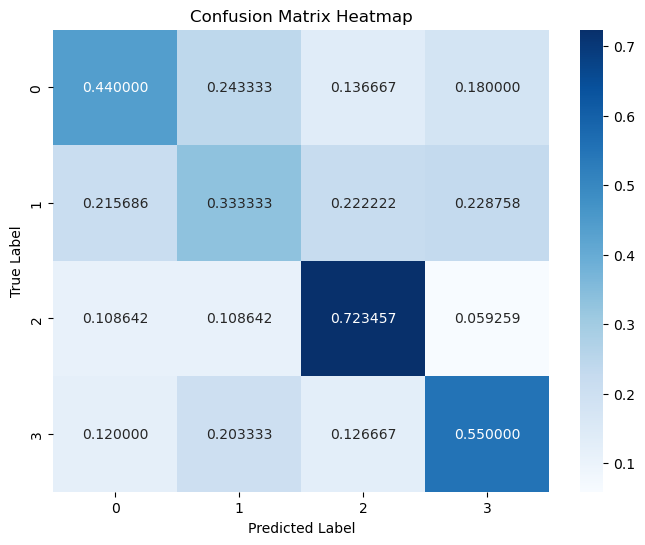

Statistic about class 0
Correctly classified as class 0: 132
Missed classified objects that in class 1: 73


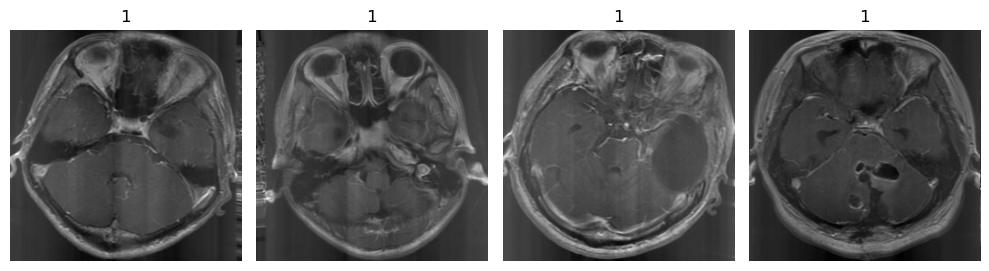

Missed classified objects that in class 2: 41


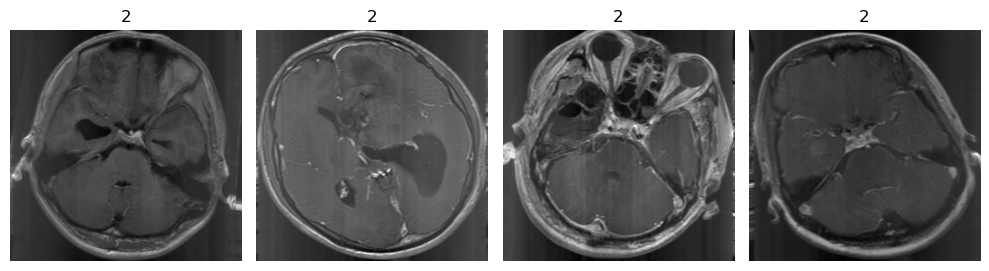

Missed classified objects that in class 3: 54


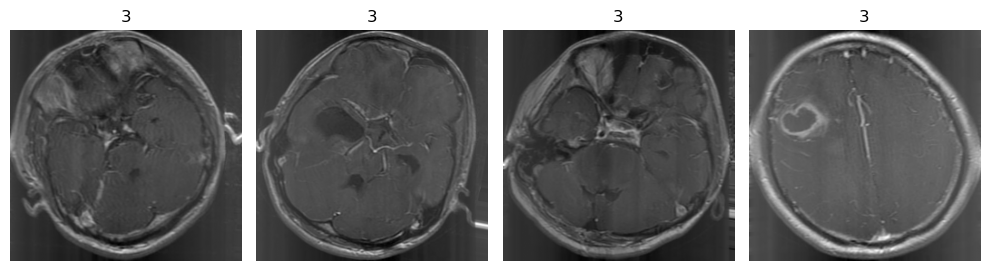

Total number of items for class in real dataset: 300
Number of false positive: 168 ~ 56.00000000000001%

Statistic about class 1
Missed classified objects that in class 2: 68


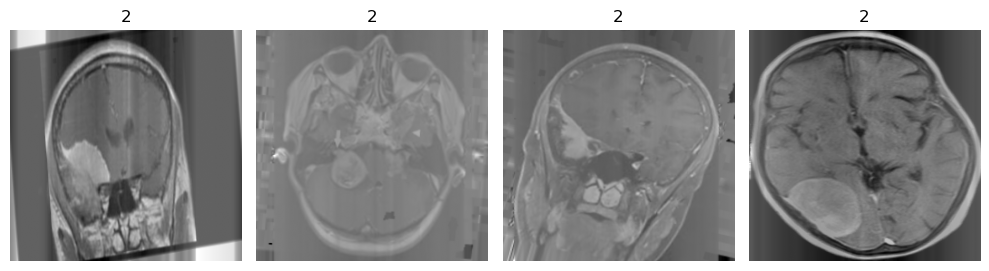

Missed classified objects that in class 0: 66


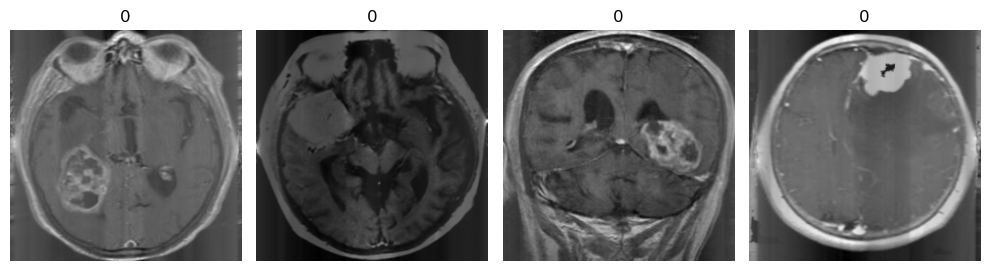

Missed classified objects that in class 3: 70


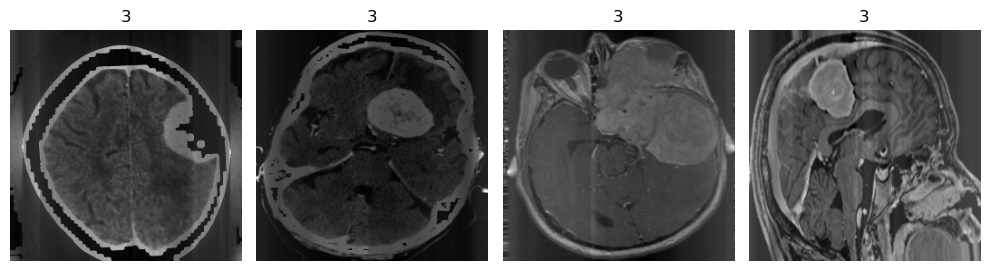

Correctly classified as class 1: 102
Total number of items for class in real dataset: 306
Number of false positive: 204 ~ 66.66666666666666%

Statistic about class 2
Missed classified objects that in class 0: 44


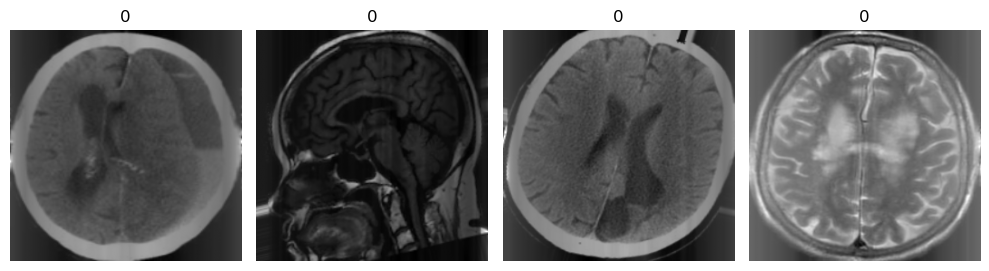

Correctly classified as class 2: 293
Missed classified objects that in class 1: 44


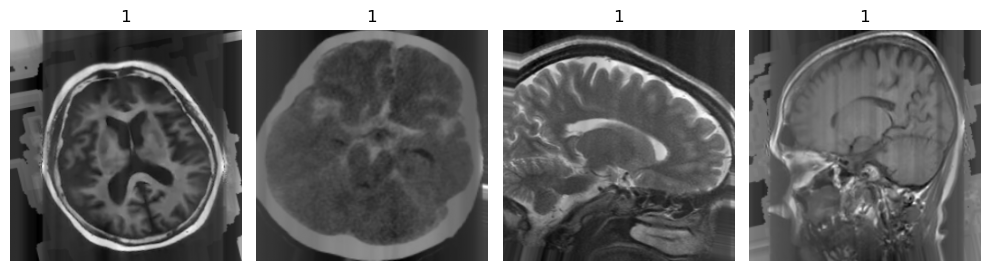

Missed classified objects that in class 3: 24


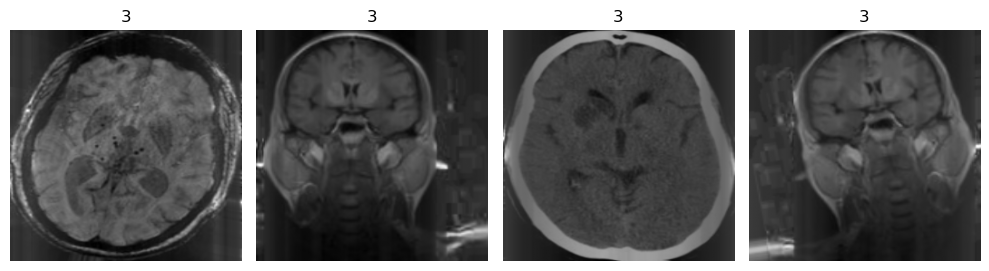

Total number of items for class in real dataset: 405
Number of false positive: 112 ~ 27.65432098765432%

Statistic about class 3
Missed classified objects that in class 2: 38


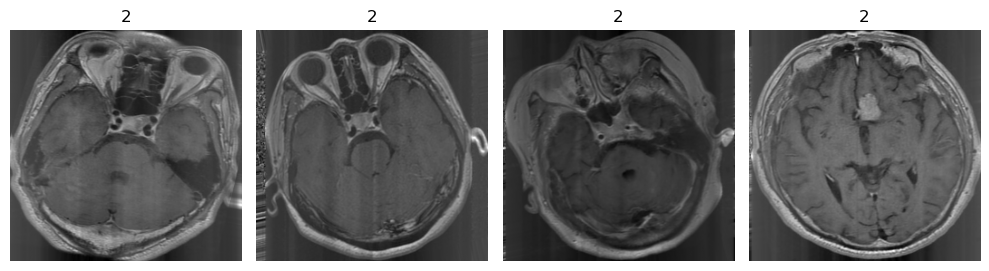

Correctly classified as class 3: 165
Missed classified objects that in class 1: 61


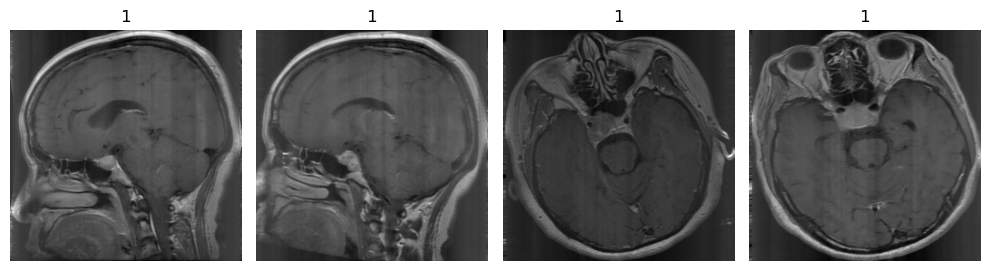

Missed classified objects that in class 0: 36


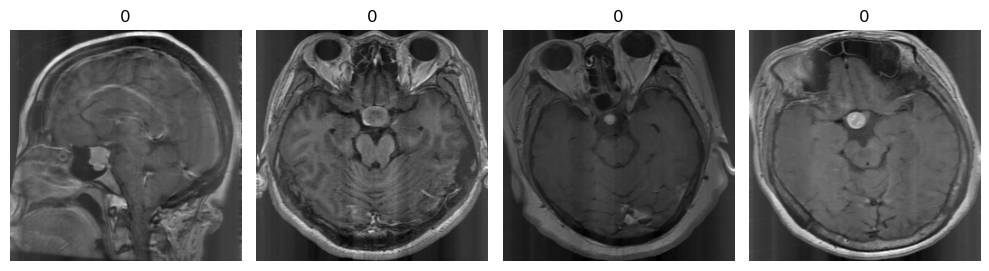

Total number of items for class in real dataset: 300
Number of false positive: 135 ~ 45.0%



In [27]:
evaluation = eval_model('decision_tree', image=True)


### **Observations & Issues**

- The model achieves an overall accuracy of 53%, indicating limited predictive power.
- Class 2 performs significantly better than others, suggesting potential data distribution issues.
- The model uses 65,536 features, which can lead to overfitting and reduced interpretability.
- Despite feature selection using max\_features = 10,000, the performance remains low, suggesting that many features might be irrelevant or redundant.
- A tree depth of 17 with 369 nodes suggests a complex model that may be capturing noise rather than generalizable patterns.
- The best cross-validation score was 48.7%, indicating that even with optimal parameters, the model struggles to generalize effectively.

### **Use Case Fit Conclusion**

The current Decision Tree model demonstrates limited effectiveness in brain tumor MRI classification due to high feature dimensionality, class imbalance, and potential overfitting. While it may provide some baseline insights, its relatively low accuracy and recall suggest that it is not well-suited for high-stakes medical applications. 

# GAUSSIAN NAIVE BAYES

Loaded saved dataset from d:\hcmut\SV242\ML\ml-pupils\src\dataset/processed/test.npz
Model loaded from d:\hcmut\SV242\ML\ml-pupils\src\results\models\naive_bayes\naive_bayes_11032025_17-51-55.pkl
              precision    recall  f1-score   support

           0       0.46      0.72      0.56       300
           1       0.49      0.31      0.38       306
           2       0.77      0.64      0.70       405
           3       0.67      0.70      0.68       300

    accuracy                           0.59      1311
   macro avg       0.60      0.59      0.58      1311
weighted avg       0.61      0.59      0.59      1311



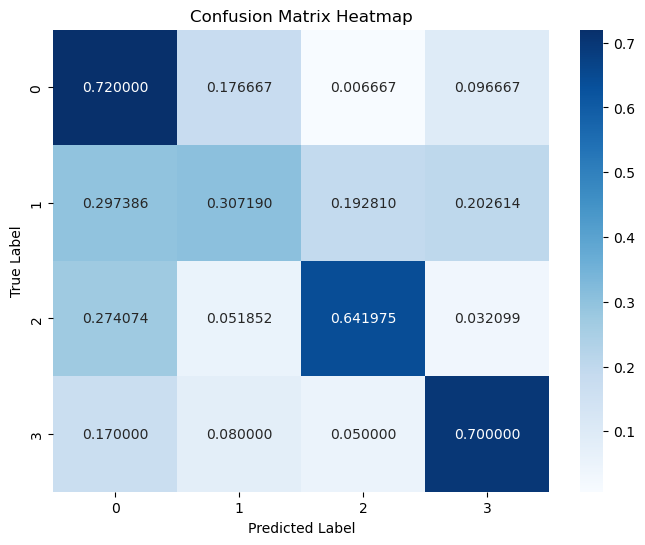

Statistic about class 0
Correctly classified as class 0: 216
Missed classified objects that in class 3: 29


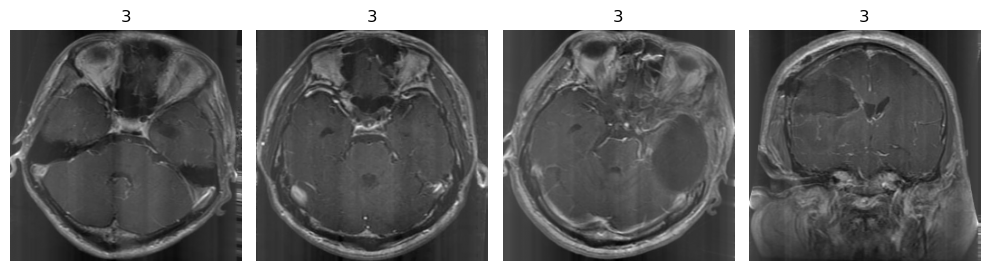

Missed classified objects that in class 1: 53


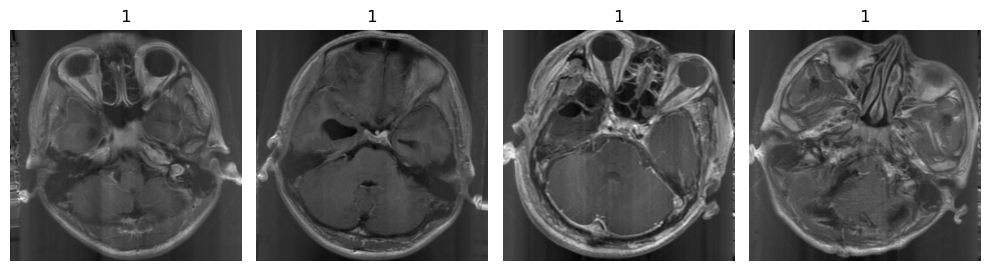

Missed classified objects that in class 2: 2


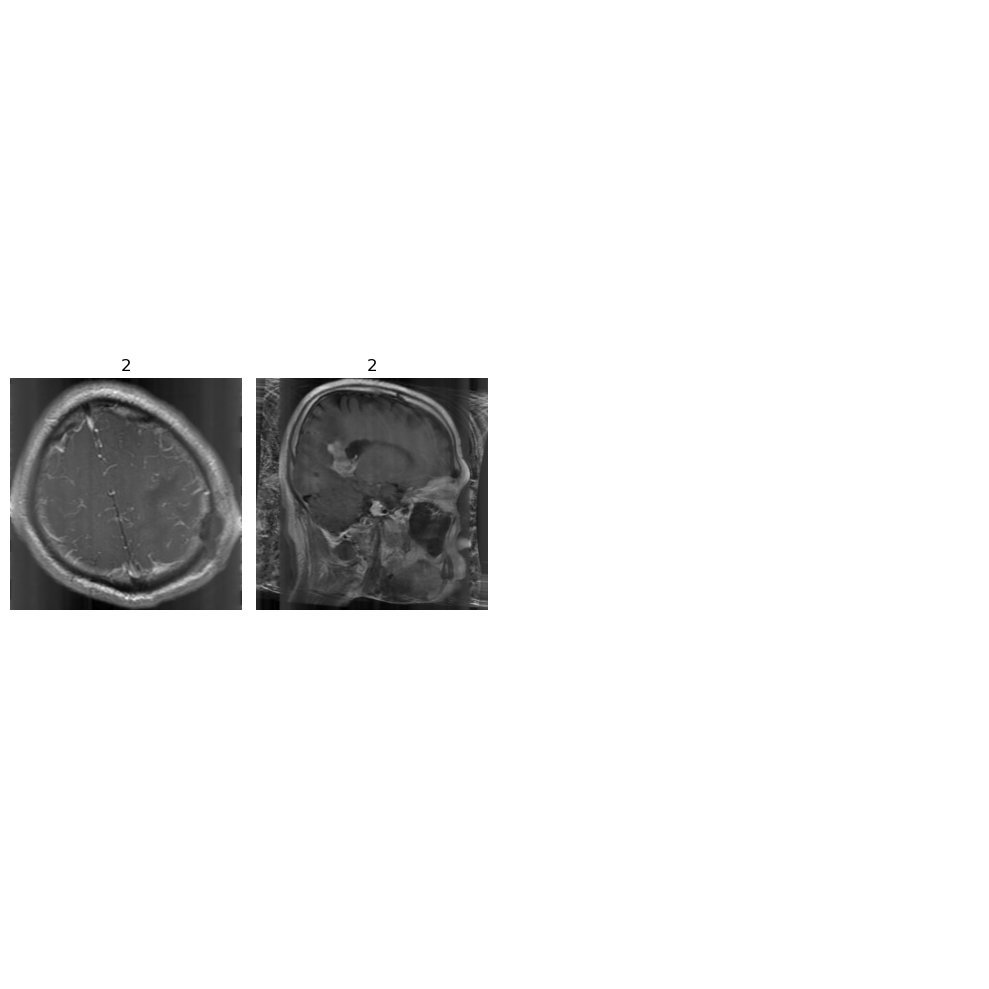

Total number of items for class in real dataset: 300
Number of false positive: 84 ~ 28.000000000000004%

Statistic about class 1
Missed classified objects that in class 2: 59


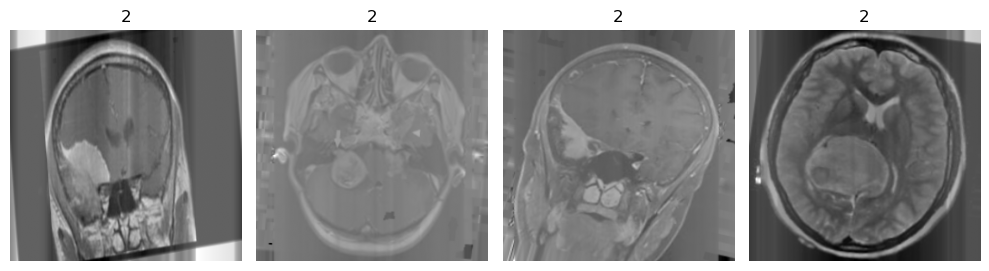

Missed classified objects that in class 3: 62


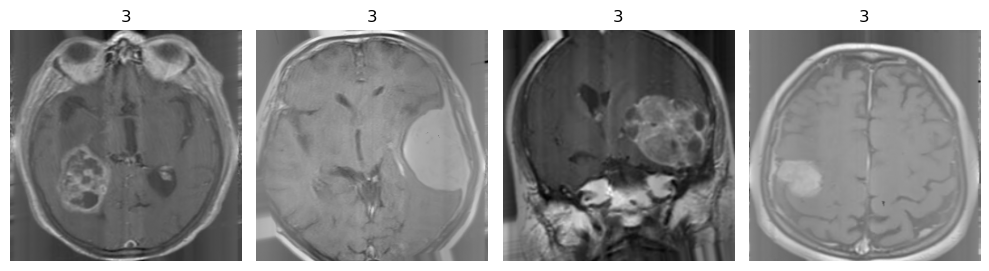

Missed classified objects that in class 0: 91


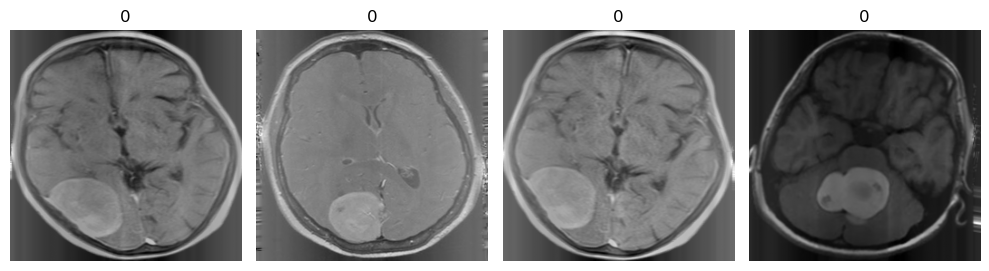

Correctly classified as class 1: 94
Total number of items for class in real dataset: 306
Number of false positive: 212 ~ 69.28104575163398%

Statistic about class 2
Missed classified objects that in class 0: 111


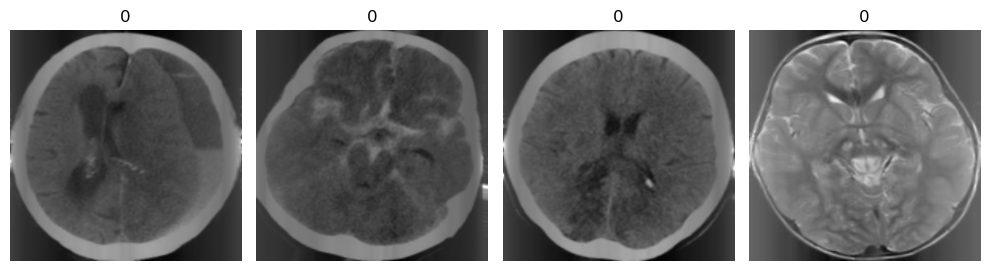

Correctly classified as class 2: 260
Missed classified objects that in class 3: 13


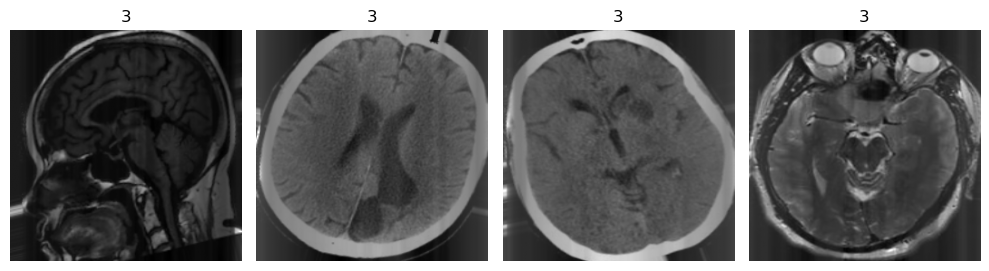

Missed classified objects that in class 1: 21


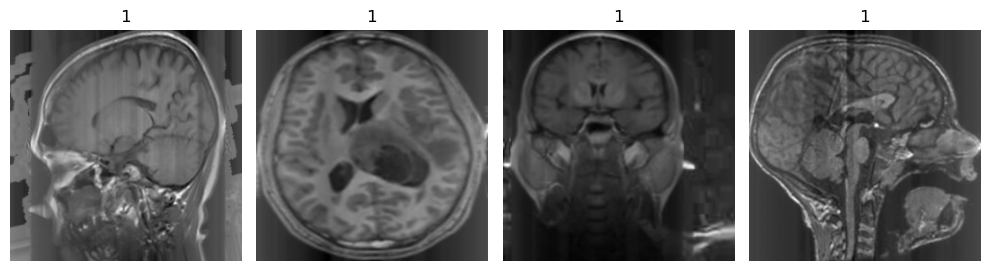

Total number of items for class in real dataset: 405
Number of false positive: 145 ~ 35.80246913580247%

Statistic about class 3
Correctly classified as class 3: 210
Missed classified objects that in class 0: 51


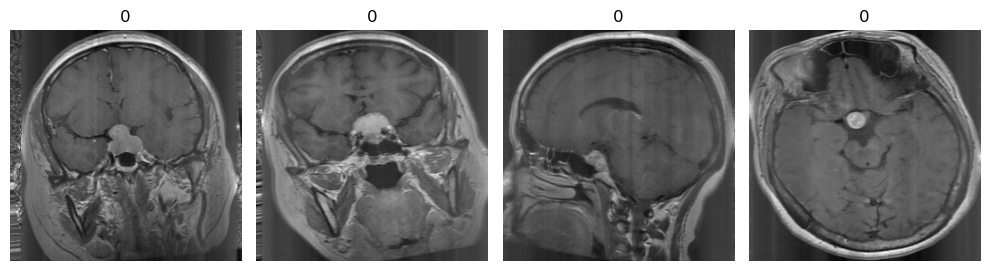

Missed classified objects that in class 1: 24


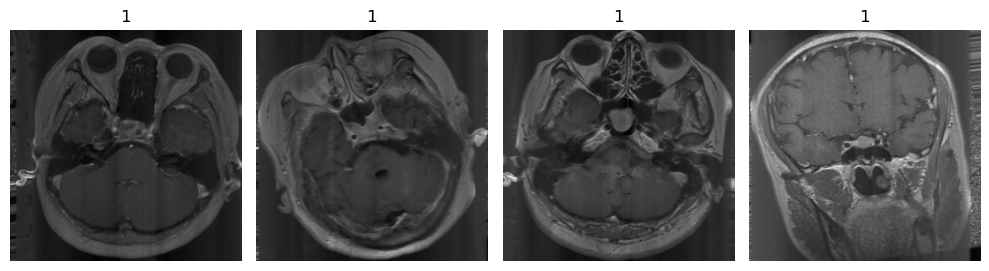

Missed classified objects that in class 2: 15


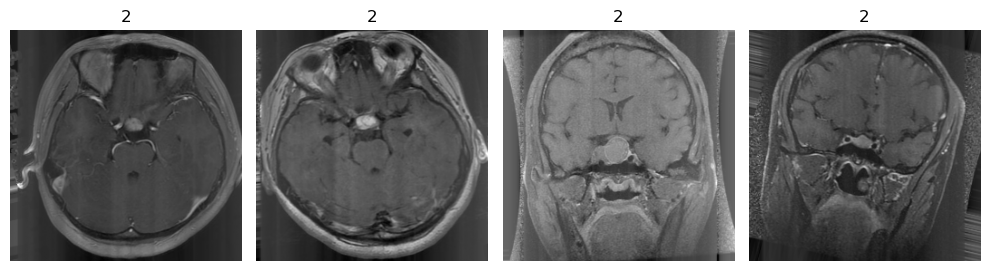

Total number of items for class in real dataset: 300
Number of false positive: 90 ~ 30.0%



[{'true_quan': np.int64(300),
  'true_positive': 216,
  np.int64(3): 29,
  np.int64(1): 53,
  np.int64(2): 2,
  'false_positive_quan': 84},
 {'true_quan': np.int64(306),
  np.int64(2): 59,
  np.int64(3): 62,
  np.int64(0): 91,
  'true_positive': 94,
  'false_positive_quan': 212},
 {'true_quan': np.int64(405),
  np.int64(0): 111,
  'true_positive': 260,
  np.int64(3): 13,
  np.int64(1): 21,
  'false_positive_quan': 145},
 {'true_quan': np.int64(300),
  'true_positive': 210,
  np.int64(0): 51,
  np.int64(1): 24,
  np.int64(2): 15,
  'false_positive_quan': 90}]

In [31]:
eval_model('naive_bayes')



### **Observations & Issues**

- The GNB model achieves an accuracy of 59%, which is an improvement over the Decision Tree but significantly lower than the ANN model.
- Class 1 shows the weakest performance with an F1-score of 0.38, indicating difficulty in distinguishing certain features.
- The model performs relatively well for Class 2 and Class 3, benefiting from assumptions of feature independence.
- Despite being computationally efficient, GNB struggles with complex spatial patterns present in MRI images.

### **Use Case Fit Conclusion**

Gaussian Naïve Bayes provides a lightweight, interpretable model for MRI classification but lacks the capacity to capture intricate spatial relationships. While it offers moderate performance, it is not ideal for high-precision medical imaging applications. More advanced models like ANN or CNNs should be considered for better accuracy and reliability.

